#  신용 카드 이상 거래 탐지 - 전통적 ML 지도학습

## Logistic Regression, Random Forest, KNN + Over/Under-sampling

- 극도로 편향된 신용카드 사기 거래 data 분류 - 지도학습 모델  

- Highly Imbalanced Dataset - 284,807 거래 건 중 492 개의 사기거래 존재


- [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) - Kaggle


- Highly Imbalanced Dataset - dataset는 2013 년 9 월 유럽 카드 소지자 신용 카드 거래로 만들었습니다. 이 dataset는 2 일 동안 발생한 거래를 보여 주며, 284,807 건의 거래 중 492 건의 fraud가 있습니다. 데이터세트는 매우 불균형하며 포지티브 클래스(사기)는 모든 거래의 0.172 %를 차지합니다.


- 이 dataset는 PCA 변환의 결과인 숫자 입력 변수만 포함합니다. 기밀 유지 문제로 인해 데이터에 대한 원래 feature와 추가 background 정보는 제공되지 않습니다. 특성 V1, V2, ... V28은 PCA로 얻은 principal component이며 PCA로 변환되지 않은 유일한 기능은 'Time' 과 'Amount' 입니다. 'Time' 특성은 각 트랜잭션과 데이터 세트의 첫 번째 트랜잭션 사이에 경과된 시간(초) 입니다. 'Amount' 특성은 거래금액 입니다.  'Class'는 사기의 경우 1, 그렇지 않으면 0 입니다.


- 클래스 불균형 비율이 주어지면 Area Under the Precision-Recall Curve (AUPRC)을 사용하여 정확도를 측정하는 것이 좋습니다. 불균형 data 분류에는 confusion matrix 정확도가 의미가 없습니다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import  accuracy_score, precision_score, recall_score, \
                            roc_curve, roc_auc_score
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

mpl.rcParams['figure.figsize'] = (12, 10)

### Kaggle Credit Card Fraud dataset 다운로드

In [2]:
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [4]:
neg, pos = df['Class'].value_counts().values.tolist()
total = neg + pos
print(f'Total 건수: {total}\nPositive 건수/비율: {pos} ({pos/total*100:.2f}%)')

Total 건수: 284807
Positive 건수/비율: 492 (0.17%)


## Data 전처리 

- 2 일 동안의 data가 00:00:00 부터 발생했으므로 Time을 일중 시간으로 변경 : time / 3600 초 % 24 시간  
- Amount column 은 편차가 크므로 log-scale 로 변환

In [5]:
cleaned_df = df.copy()

# Time 을 일중 시간으로 변환
cleaned_df.loc[:, "Time"] = cleaned_df.loc[:, "Time"].apply(lambda x : x / 3600 % 24) 

# Amount column 은 편차가 크므로 log-scale 로 변환
eps=0.001     
cleaned_df['Amount'] = np.log(cleaned_df.pop('Amount') + eps)

cleaned_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.008105
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.989913
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.936641
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.816249
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.248367


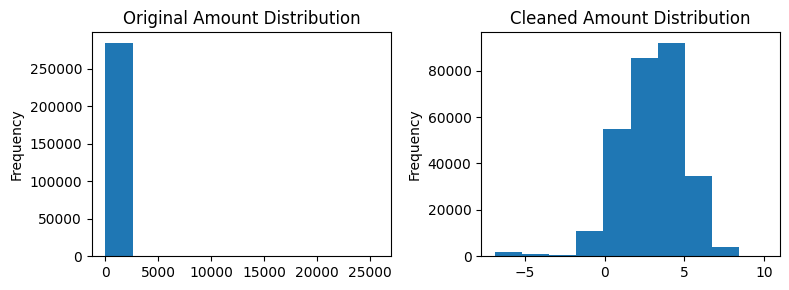

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# 첫 번째 서브플롯 (ax1)에 df 데이터프레임의 'Amount' 열의 히스토그램을 그립니다.
df['Amount'].plot(kind='hist', ax=ax1)
ax1.set_title('Original Amount Distribution') 

# 두 번째 서브플롯 (ax2)에 cleaned_df 데이터프레임의 'Amount' 열의 히스토그램을 그립니다.
cleaned_df['Amount'].plot(kind='hist', ax=ax2)
ax2.set_title('Cleaned Amount Distribution') 

# 서브플롯들 간의 레이아웃을 조정하여 겹치지 않도록 합니다.
plt.tight_layout()
plt.show()

In [7]:
# cleaned_df 데이터프레임에서 'Class' 열을 추출하여 NumPy 배열로 변환합니다.
# 'Class' 열은 레이블로 사용됩니다.
labels = np.array(cleaned_df.pop('Class'))
print(labels) 

[0 0 0 ... 0 0 0]


In [8]:
# cleaned_df 데이터프레임의 값을 NumPy 배열로 변환하여 features에 저장합니다.
# 'Class' 열이 제거된 데이터프레임의 값만 포함됩니다.
features = cleaned_df.values

# features 배열의 형태(shape)를 출력합니다.
print(features.shape)  

(284807, 30)


<Axes: ylabel='count'>

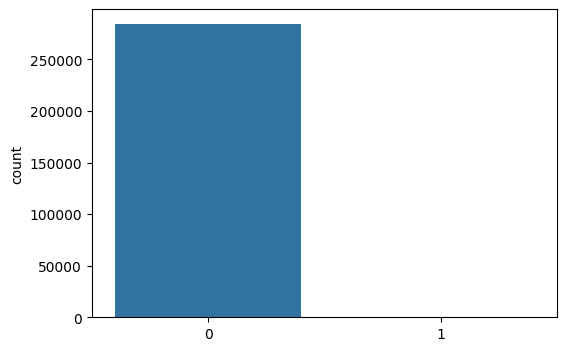

In [9]:
plt.figure(figsize=(6, 4))
sns.countplot(x=labels)

### Dataset 을 Training 과 Test set 으로 분리

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, 
                         test_size=0.5, random_state=0, stratify=labels)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((142403, 30), (142404, 30), (142403,), (142404,))

In [11]:
print("전체 data의 positive 건수 : ", Counter(labels))
print("Train set 의 positive 건수 : ", Counter(y_train))
print("Test set 의 positive 건수 : ", Counter(y_test))

전체 data의 positive 건수 :  Counter({0: 284315, 1: 492})
Train set 의 positive 건수 :  Counter({0: 142157, 1: 246})
Test set 의 positive 건수 :  Counter({0: 142158, 1: 246})


### Feature Scaling

In [12]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

## 1-1. Logistic Regression model 학습

In [13]:
lr  = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)

LogisticRegression(random_state=0)

### 훈련된 모델을 이용하여 Test set 예측
- predict_proba() - class 의 probability 반환 ([negative 확률, positive 확률])

In [14]:
# y_pred_prob에는 각 샘플이 클래스 1에 속할 확률이 저장됩니다.
# 각 샘플에 대해 클래스 1에 속할 확률만을 선택합니다.
y_pred_prob = lr.predict_proba(X_test)[:, 1]

print(y_pred_prob)

[1.63049440e-04 4.00934098e-04 4.84967018e-04 ... 5.07305252e-04
 3.67062330e-05 1.32868630e-04]


In [15]:
y_pred = y_pred_prob > 0.5

print("Test set positive 건수 = ", sum(y_test))
print("Predicted positive 건수 = ", sum(y_pred))
print("accuracy = {:.5f}".format(accuracy_score(y_test, y_pred)))

Test set positive 건수 =  246
Predicted positive 건수 =  173
accuracy = 0.99921


## confusion matrix 를 이용한 model 성능 평가

In [16]:
def plot_cm(y_test, y_pred_proba, threshold):
    # 주어진 임계값(threshold)을 기준으로 예측 확률을 이진 예측값으로 변환합니다.
    y_pred = y_pred_proba > threshold

    cm = confusion_matrix(y_test, y_pred)

    print("f1 score:", f1_score(y_test, y_pred))
    print("Accuracy", accuracy_score(y_test, y_pred))
    print("Precision", precision_score(y_test, y_pred))
    print("Recall", recall_score(y_test, y_pred))

    # 혼동 행렬을 시각화합니다.
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")  
    plt.title('Confusion matrix (threshold>{:.2f}) '.format(threshold))  
    plt.ylabel('Actual label') 
    plt.xlabel('Predicted label')  
    plt.show()

f1 score: 0.7303102625298329
Accuracy 0.9992064829639616
Precision 0.884393063583815
Recall 0.6219512195121951


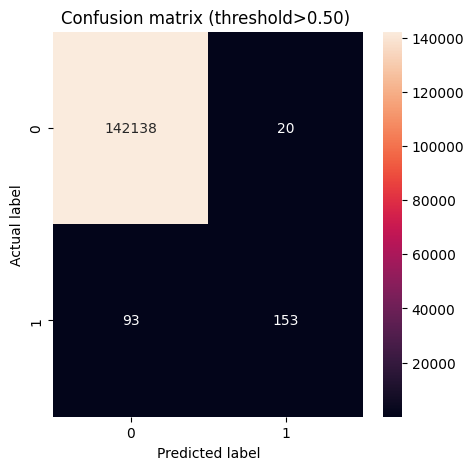

In [17]:
plot_cm(y_test, y_pred_prob, 0.5)

### Fraud 거래를 잡아내는 것이 목적이므로, fraud case 를 놓치지 않으려면 recall 을 높인다.

이를 위해 threshold 를 0.2 로 조정.

f1 score: 0.7688984881209503
Accuracy 0.9992486166118929
Precision 0.8202764976958525
Recall 0.7235772357723578


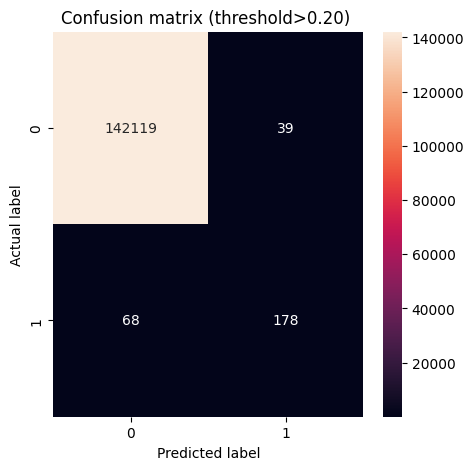

In [18]:
plot_cm(y_test, y_pred_prob, 0.2)

## 불균형 데이터에 대한 Resampling 기법 적용
     
- minority class를 oversample 하고 majority class를 undersample  
- minority data 의 수(비율)를 증가시켜 새로이 fitting  

In [19]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

- 소수 class 비율이 10%가 되도록 소수 class를 oversample  
- `sampling_strategy` parameter는 리샘플링 후 다수 클래스에 대한 소수 클래스의  비율

In [20]:
# 소수 클래스 샘플 수를 다수 클래스 샘플 수의 10%로 설정합니다.
over = RandomOverSampler(sampling_strategy=0.1)

# 학습 데이터(X_train, y_train)를 오버샘플링합니다.
X, y = over.fit_resample(X_train, y_train)

print(X.shape, y.shape)

# 오버샘플링된 y 데이터의 클래스 분포를 출력합니다.
print(Counter(y))

(156372, 30) (156372,)
Counter({0: 142157, 1: 14215})


- 소수 class 비율이 50%가 되도록 다수 class를 undersample

In [21]:
# 소수 클래스 샘플 수를 다수 클래스 샘플 수의 50%로 설정합니다.
under = RandomUnderSampler(sampling_strategy=0.5)

# 데이터(X, y)를 언더샘플링합니다.
X, y = under.fit_resample(X, y)

print(X.shape, y.shape)

# 언더샘플링된 y 데이터의 클래스 분포를 출력합니다.
print(Counter(y))

(42645, 30) (42645,)
Counter({0: 28430, 1: 14215})


- Data 시각화 

<Axes: ylabel='count'>

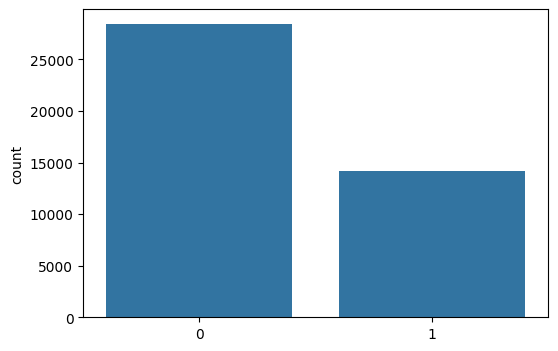

In [22]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y)

## 1-2.  Logistic Regression model 재학습

In [23]:
# max_iter=1000은 최대 반복 횟수를 1000으로 설정하여 모델이 수렴할 때까지 충분히 학습할 수 있도록 합니다.
re_lr = LogisticRegression(max_iter=1000, random_state=0)

re_lr.fit(X, y)

LogisticRegression(max_iter=1000, random_state=0)

- 학습된 모델을 이용하여 Test set 예측

In [24]:
# 각 샘플에 대해 클래스 1에 속할 확률만을 선택합니다.
y_pred_prob = re_lr.predict_proba(X_test)[:, 1]

print(y_pred_prob)

[0.04028174 0.01175453 0.02408246 ... 0.0056415  0.00252732 0.03038443]


In [25]:
y_pred = y_pred_prob > 0.5

print("Test set positive 건수 = ", sum(y_test))
print("Predicted positive 건수 = ", sum(y_pred))
print("accuracy = {:.5f}".format(accuracy_score(y_test, y_pred)))

Test set positive 건수 =  246
Predicted positive 건수 =  1649
accuracy = 0.98971


f1 score: 0.2269129287598945
Accuracy 0.9897123676301227
Precision 0.13038204972710735
Recall 0.8739837398373984


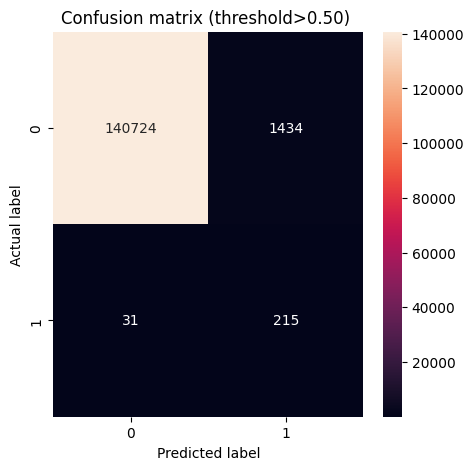

In [26]:
plot_cm(y_test, y_pred_prob, 0.5)

oversample + undersample 기법 적용 결과 precision(positive로 예측한 내용 중에, 실제 Positive의 비율)은 크게 낮아지고,  recall(전체 positive 데이타 중에서 positive로 분류한 비율)이 높아짐.

## 2. RandomForest model을 이용한 분류

oversample + undersample 한 data 를  random forest model을 이용하여 분류

In [27]:
# n_estimators=1000: 1000개의 의사결정 트리를 사용합니다.
# max_depth=12: 각 트리의 최대 깊이를 12로 설정합니다.
# min_samples_leaf=50: 각 리프 노드(leaf node)에 필요한 최소 샘플 수를 50으로 설정합니다.
# min_samples_split=6: 내부 노드를 분할하는 데 필요한 최소 샘플 수를 6으로 설정합니다.
# n_jobs=-1: 가능한 모든 프로세서를 사용하여 병렬로 작업을 수행합니다.
# verbose=1: 학습 과정의 진행 상황을 출력합니다.
rf = RandomForestClassifier(n_estimators=1000, 
                            max_depth=12, min_samples_leaf=50,
                            min_samples_split=6, n_jobs=-1, verbose=1)
rf.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   13.7s finished


RandomForestClassifier(max_depth=12, min_samples_leaf=50, min_samples_split=6,
                       n_estimators=1000, n_jobs=-1, verbose=1)

In [28]:
y_pred_prob = rf.predict_proba(X_test)[:, 1]

y_pred = y_pred_prob > 0.5

print("Test set의 positive 건수 = ", sum(y_test))
print("Prediction의 positive  건수 = ", sum(y_pred))
print("accuracy = {:.5f}".format(sum(y_pred == y_test) / len(y_test)))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.6s


Test set의 positive 건수 =  246
Prediction의 positive  건수 =  300
accuracy = 0.99903


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.0s finished


f1 score: 0.7472527472527474
Accuracy 0.9990309260975815
Precision 0.68
Recall 0.8292682926829268


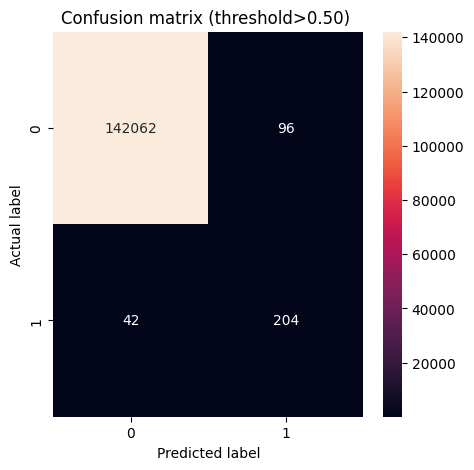

In [29]:
plot_cm(y_test, y_pred_prob, 0.5)

## 3. K-Nearest Neighbors model을 이용한 분류

oversample + undersample 한 data를  K-Nearest Neighbors model을 이용하여 분류

In [30]:
knn = KNeighborsClassifier(n_neighbors=15, weights='uniform')
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=15)

In [31]:
%%time
y_pred_prob = knn.predict_proba(X_test)[:, 1]

y_pred = y_pred_prob > 0.5

print("Test set의 positive 건수 = ", sum(y_test))
print("Prediction의 positive  건수 = ", sum(y_pred))
print("accuracy = {:.5f}".format(sum(y_pred == y_test) / len(y_test)))

Test set의 positive 건수 =  246
Prediction의 positive  건수 =  1034
accuracy = 0.99392
Wall time: 3.66 s


f1 score: 0.3234375
Accuracy 0.9939187101485913
Precision 0.20019342359767892
Recall 0.8414634146341463


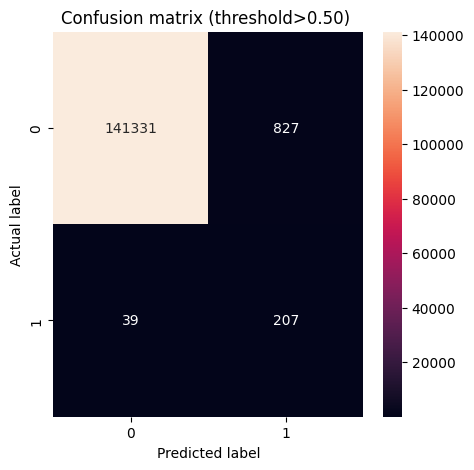

In [32]:
plot_cm(y_test, y_pred_prob, 0.5)

## ROC(Receiver Operating Characteristic) curve 시각화로 모델 설능 비교
``` fpr, tpr, _ = roc_curve(y_true, y_score) ```
- fpr - false positive rates,  tpr - true positive rates

In [33]:
def plot_roc(name, labels, predictions, **kwargs):
    # ROC 곡선을 그리기 위한 FPR(위양성률)과 TPR(진양성률)을 계산합니다.
    fpr, tpr, _ = roc_curve(labels, predictions)
    # AUC(Area Under the Curve) 값을 계산합니다.
    auc = roc_auc_score(labels, predictions)
    
    # ROC 곡선을 그립니다. FPR을 x축, TPR을 y축으로 설정합니다.
    # label은 모델 이름과 AUC 값을 포함하며, linewidth는 선의 두께를 설정합니다.
    plt.plot(100*fpr, 100*tpr, label=f"{name}={auc:.5f}", linewidth=2, **kwargs)
    plt.title("ROC Curve")
    plt.xlabel('FPR [%]')
    plt.ylabel('TPR [%]')
    # x축의 범위를 설정합니다.
    plt.xlim([-0.5, 40])
    # y축의 범위를 설정합니다.
    plt.ylim([80, 100.5])
    # 현재 그래프의 Figure 객체를 가져옵니다.
    fig = plt.gcf()
    fig.set_size_inches(8, 6)
    # 범례를 오른쪽 아래에 추가합니다.
    plt.legend(loc='lower right')

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.0s finished


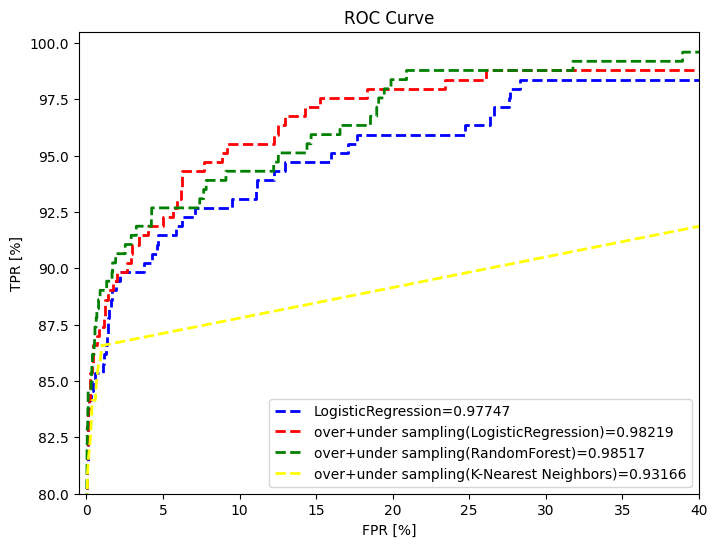

In [34]:
y_prob = lr.predict_proba(X_test)[:,1]
plot_roc("LogisticRegression", y_test, y_prob, 
         color='blue', linestyle='--')

y_prob = re_lr.predict_proba(X_test)[:,1]
plot_roc("over+under sampling(LogisticRegression)", y_test, y_prob, color='red', linestyle='--')

y_prob = rf.predict_proba(X_test)[:,1]
plot_roc("over+under sampling(RandomForest)", y_test, y_prob, color='green', linestyle='--')

y_prob = knn.predict_proba(X_test)[:,1]
plot_roc("over+under sampling(K-Nearest Neighbors)", y_test, y_prob, color='yellow', linestyle='--')

## IE (Integrated Error)

- FRR : False Rejection Rate  

- FAR : False Acceptance Rate

FRR = FNR = FN/(FN + TN)  
FAR = FPR = FP/(FP + FN)  

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.0s finished


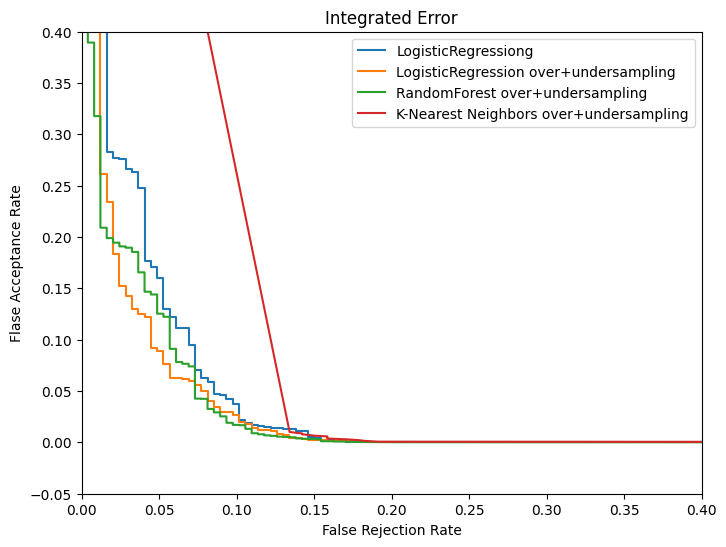

In [35]:
plt.figure(figsize=(8, 6))

y_prob = lr.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
fnr = 1 - tpr
plt.plot(fnr, fpr, label='LogisticRegressiong')

y_prob = re_lr.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
fnr = 1 - tpr
plt.plot(fnr, fpr, label='LogisticRegression over+undersampling')

y_prob = rf.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
fnr = 1 - tpr
plt.plot(fnr, fpr, label='RandomForest over+undersampling')

y_prob = knn.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
fnr = 1 - tpr
plt.plot(fnr, fpr, label='K-Nearest Neighbors over+undersampling')

plt.title("Integrated Error")
plt.xlabel('False Rejection Rate')
plt.ylabel('Flase Acceptance Rate')
plt.xlim([0, 0.4])
plt.ylim([-0.05, 0.4])
plt.legend()